In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
import pickle

import numpy as np
import pandas as pd

# Set the seed for Keras
np.random.seed(4)

from model.model import get_model, split_train_test

from model.predictions import fit_model, predict, assemble_submission, convert_predictions, AMAPE

from utils.visualisations import PenguinVisualisation

Using Theano backend.


In [4]:
fname = '../data/interim/Submission_02/features_weighted.p'
df_train, df_test, df_features, df_featuresNoise, features, scaler = pickle.load(open(fname, 'rb'))

In [5]:
print(df_train.shape, df_test.shape)
df_train.head()

(77648, 38) (1296, 38)


y_true inferred_y_true inferred_t        t0  \
site_id species        year                                                
ACUN    adelie penguin 1984     1.0            True       True  1.000000   
                       1984     1.0            True       True  0.949266   
                       1985     1.0            True       True  1.000000   
                       1985     1.0            True       True  0.697282   
                       1985     1.0            True       True  1.281293   

                                   t1        t2        t3  countError  \
site_id species        year                                             
ACUN    adelie penguin 1984  1.000000  1.000000  1.000000    0.707107   
                       1984  0.897527  0.835830  1.191636    0.707107   
                       1985  1.000000  1.000000  1.000000    0.707107   
                       1985  1.163350  1.330612  1.267430    0.707107   
                       1985  0.999324  0.976007  1.189787    0.707107   

                             adelie penguin  chinstrap penguin      ...        \
site_id species        year                                         ...         
ACUN    adelie penguin 1984             1.0                0.0      ...         
                       1984             1.0                0.0      ...         
                       1985             1.0                0.0      ...         
                       1985             1.0                0.0      ...         
                       1985             1.0                0.0      ...         

                             temp_month_2  temp_month_3  temp_month_4  \
site_id species        year                                             
ACUN    adelie penguin 1984     -0.210000      0.380000     -0.270000   
                       1984      0.149992     -0.237135     -0.382182   
                       1985      1.590000      0.530000     -0.320000   
                       1985      1.870183      0.678651     -0.293679   
                       1985      2.187079      0.558696      0.123768   

                             temp_month_5  temp_month_6  temp_month_7  \
site_id species        year                                             
ACUN    adelie penguin 1984     -0.280000      2.390000     -3.260000   
                       1984     -1.420290      0.680197     -3.469350   
                       1985      1.420000      0.490000     -1.650000   
                       1985      1.143583      0.938009     -2.537848   
                       1985      1.872761      1.006667     -0.959857   

                             temp_month_8  temp_month_9  temp_month_10  \
site_id species        year                                              
ACUN    adelie penguin 1984     -0.480000      3.940000       4.120000   
                       1984      0.056388      3.409922       4.999294   
                       1985      5.430000      4.250000       4.070000   
                       1985      4.937228      4.420673       5.094243   
                       1985      6.641017      5.393450       3.703621   

                             temp_month_11  
site_id species        year                 
ACUN    adelie penguin 1984      -0.490000  
                       1984      -0.330559  
                       1985       0.760000  
                       1985       0.070614  
                       1985       0.606456  

[5 rows x 38 columns]

In [6]:
df_train.columns

Index(['y_true', 'inferred_y_true', 'inferred_t', 't0', 't1', 't2', 't3',
       'countError', 'adelie penguin', 'chinstrap penguin', 'gentoo penguin',
       'proximityNestCountChange', 'siteCount', 'sea_ice_month_0',
       'sea_ice_month_1', 'sea_ice_month_2', 'sea_ice_month_3',
       'sea_ice_month_4', 'sea_ice_month_5', 'sea_ice_month_6',
       'sea_ice_month_7', 'sea_ice_month_8', 'sea_ice_month_9',
       'sea_ice_month_10', 'sea_ice_month_11', 'krill', 'temp_month_0',
       'temp_month_1', 'temp_month_2', 'temp_month_3', 'temp_month_4',
       'temp_month_5', 'temp_month_6', 'temp_month_7', 'temp_month_8',
       'temp_month_9', 'temp_month_10', 'temp_month_11'],
      dtype='object')

In [7]:
# Get the model
ts_steps = 4
aux_input_size = 6
model = get_model(ts_steps, aux_input_size=aux_input_size)

In [8]:
# Run the fitting
batch_size = 256
model, history = fit_model(df_train, model, df_test, batch_size=batch_size, epochs=200, verbose=0)

Epoch with lowest validation loss is epoch 40 with a loss of 0.19
Manually chosen epoch is epoch 40 with a loss of 0.19


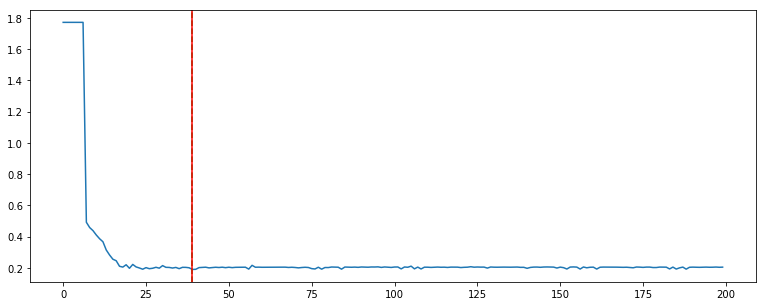

In [9]:
# Show the history of the validation loss and select the "best" number of epochs to run
val_loss = history.history['val_loss']
best_epoch_auto = np.argmin(val_loss) + 1
best_epoch = best_epoch_auto

print("Epoch with lowest validation loss is epoch %i with a loss of %.2f" %(best_epoch_auto, val_loss[best_epoch_auto]))
print("Manually chosen epoch is epoch %i with a loss of %.2f" %(best_epoch, val_loss[best_epoch]))


fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(val_loss)
ax.axvline(best_epoch-1, color='green', linestyle='dashed');
ax.axvline(best_epoch_auto-1, color='red');

In [10]:
# Get the model
np.random.seed(4)
ts_steps = 4
aux_input_size = 6
model = get_model(ts_steps, aux_input_size=aux_input_size)
model, history = fit_model(df_train, model, df_test, batch_size=batch_size, epochs=best_epoch, verbose=0)

Epoch with lowest validation loss is epoch 40 with a loss of 0.19


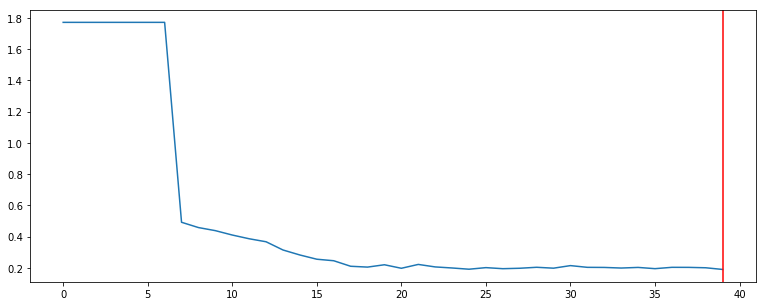

In [11]:
val_loss_re = history.history['val_loss']
best_epoch_re = np.argmin(val_loss_re) + 1

print("Epoch with lowest validation loss is epoch %i with a loss of %.2f" %(best_epoch_re, val_loss_re[best_epoch_re-1]))

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(val_loss_re)
ax.axvline(best_epoch_re-1, color='red');

In [12]:
# Predict the steps ahead
df_predictions = predict(df_features, 4, model, features)
df_predictions.head()

adelie penguin  chinstrap penguin  countError  \
site_id species        year                                                  
ACUN    adelie penguin 1984             1.0                0.0    0.707107   
                       1985             1.0                0.0    0.707107   
                       1986             1.0                0.0    0.707107   
                       1987             1.0                0.0    0.707107   
                       1988             1.0                0.0    0.707107   

                             gentoo penguin inferred_t  inferred_y_true  \
site_id species        year                                               
ACUN    adelie penguin 1984             0.0       True              1.0   
                       1985             0.0       True              1.0   
                       1986             0.0       True              1.0   
                       1987             0.0       True              1.0   
                       1988             0.0       True              1.0   

                                krill  proximityNestCountChange  \
site_id species        year                                       
ACUN    adelie penguin 1984  1.051298                  0.981254   
                       1985  5.788702                  0.980524   
                       1986  0.000000                  0.979735   
                       1987  0.000000                  0.978878   
                       1988  4.264471                  0.977947   

                             sea_ice_month_0  sea_ice_month_1   ...    \
site_id species        year                                     ...     
ACUN    adelie penguin 1984         0.028333         0.000000   ...     
                       1985         0.000000         0.000000   ...     
                       1986         0.060278         0.006667   ...     
                       1987         0.043889         0.000278   ...     
                       1988         0.083611         0.055741   ...     

                             temp_month_2  temp_month_3  temp_month_4  \
site_id species        year                                             
ACUN    adelie penguin 1984         -0.21          0.38         -0.27   
                       1985          1.59          0.53         -0.32   
                       1986          0.55          0.43          1.13   
                       1987          0.25          0.37          0.68   
                       1988          0.24          0.93          0.93   

                             temp_month_5  temp_month_6  temp_month_7  \
site_id species        year                                             
ACUN    adelie penguin 1984         -0.28          2.39         -3.26   
                       1985          1.42          0.49         -1.65   
                       1986          1.22          0.29          3.89   
                       1987         -0.48          0.69         -2.00   
                       1988          0.26          1.74         -1.30   

                             temp_month_8  temp_month_9    y_pred  y_true  
site_id species        year                                                
ACUN    adelie penguin 1984         -0.48          3.94  0.999743     1.0  
                       1985          5.43          4.25  0.999743     1.0  
                       1986          0.27          0.44  0.999743     1.0  
                       1987         -5.22          1.80  0.999743     1.0  
                       1988          0.12         -4.30  0.999743     1.0  

[5 rows x 39 columns]

In [13]:
# Rescale the predictions
df_predictions = convert_predictions(df_predictions, scaler)
df_predictions.head()

year                                1984           1985           1986  \
site_id species                                                          
ACUN    adelie penguin       2007.484153    2007.484153    2007.484153   
        chinstrap penguin    3998.972416    3998.972416    3998.972416   
ADAM    adelie penguin         75.980476      75.980476      75.980476   
ADAR    adelie penguin     256740.410232  265238.841359  273737.208112   
AILS    chinstrap penguin    5998.458624    5998.458624    5998.458624   

year                                1987           1988           1989  \
site_id species                                                          
ACUN    adelie penguin       2007.484153    2007.484153    2007.484153   
        chinstrap penguin    3998.972416    3998.972416    3998.972416   
ADAM    adelie penguin         75.980476      75.980476      75.980476   
ADAR    adelie penguin     282234.981260  277251.306543  272265.424002   
AILS    chinstrap penguin    5998.458624    5998.458624    5998.458624   

year                                1990           1991           1992  \
site_id species                                                          
ACUN    adelie penguin       2007.484153    2007.484153    2007.484153   
        chinstrap penguin    3998.972416    3998.972416    3998.972416   
ADAM    adelie penguin         75.980476      75.980476      75.980476   
ADAR    adelie penguin     220707.587611  169156.805491  233264.175160   
AILS    chinstrap penguin    5998.458624    5998.458624    5998.458624   

year                                1993      ...                 2008  \
site_id species                               ...                        
ACUN    adelie penguin       2007.484153      ...          2478.888151   
        chinstrap penguin    3998.972416      ...          3998.972416   
ADAM    adelie penguin         75.980476      ...            75.980476   
ADAR    adelie penguin     297369.850211      ...        338280.574736   
AILS    chinstrap penguin    5998.458624      ...          5998.458624   

year                                2009           2010           2011  \
site_id species                                                          
ACUN    adelie penguin       2678.670256    2878.452247    3078.226268   
        chinstrap penguin    3998.972416    3998.972416    3998.972416   
ADAM    adelie penguin         75.980476      75.980476      75.980476   
ADAR    adelie penguin     338235.086425  338189.598114  338145.440372   
AILS    chinstrap penguin    5998.458624    5998.458624    5998.458624   

year                                2012           2013           2014  \
site_id species                                                          
ACUN    adelie penguin       3078.219478    3078.214156    3078.209017   
        chinstrap penguin    3998.972416    3998.972416    3998.972416   
ADAM    adelie penguin         75.980476      75.980476      75.980476   
ADAR    adelie penguin     368233.683681  398321.710690  428408.495641   
AILS    chinstrap penguin    5998.458624    5998.458624    5998.458624   

year                                2015           2016           2017  
site_id species                                                         
ACUN    adelie penguin       3077.418238    3076.627661    3075.837104  
        chinstrap penguin    3997.945096    3996.918040    3995.891009  
ADAM    adelie penguin         75.960957      75.941443      75.921929  
ADAR    adelie penguin     428299.996848  428190.734144  428080.708127  
AILS    chinstrap penguin    5996.917644    5995.377059    5993.836514  

[5 rows x 34 columns]

AMAPE 2011: 0.20
AMAPE 2012: 0.34
AMAPE 2013: 0.40
Projected AMAPE score: 0.94


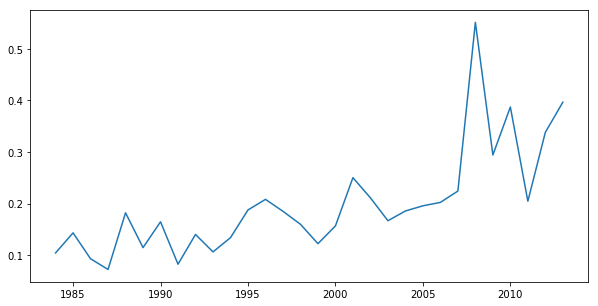

In [14]:
# Show some estimate of what the final score for the test set would be.
# First, show the score for all data (i.e. including the interpolated counts)
amape = AMAPE(interpolated=True)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

AMAPE 2011: 1.53
AMAPE 2012: 1.95
AMAPE 2013: 3.13
Projected AMAPE score: 6.61


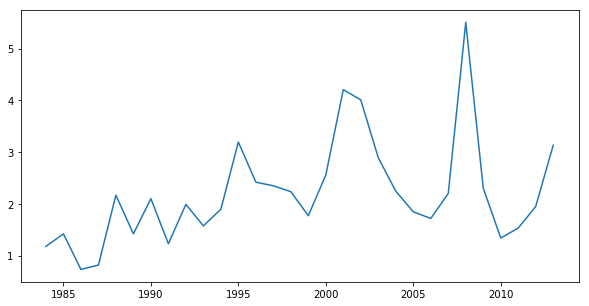

In [15]:
# Show the score only for the truly observed predictions. This will be harder to predict since the interpolated
# data is smooth and thus much easier to predict.
amape = AMAPE(interpolated=False)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

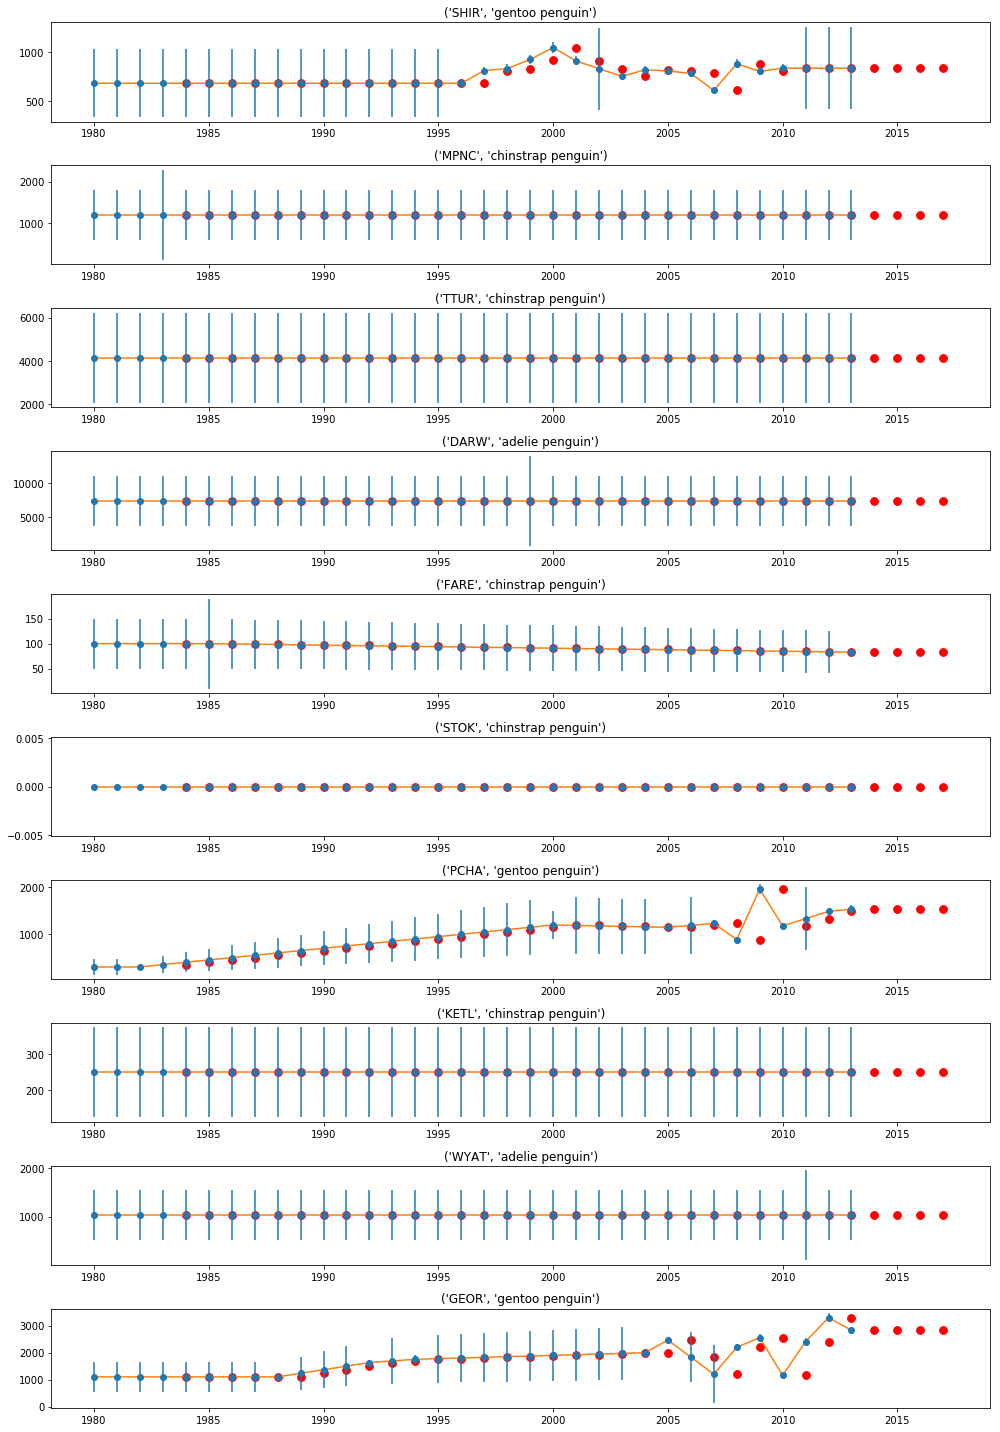

In [16]:
# Have look at some random sites and species and check if the model seems to make sense
vis = PenguinVisualisation(df_predictions)
vis.plot_random()

In [17]:
# Finally, retrain the model with the full data and make the predictions for the submission
np.random.seed(4)
model = get_model(ts_steps, aux_input_size=aux_input_size)
model, _ = fit_model(df_featuresNoise, model, None, batch_size=batch_size, epochs=best_epoch, verbose=0)

# Make the predictions
df_predictions = predict(df_features, 4, model, features)
df_predictions = convert_predictions(df_predictions, scaler)

# Prepare the submission
df_submission = assemble_submission(df_predictions)
df_submission.head()

2014           2015           2016  \
site_id common_name                                                      
ACUN    adelie penguin       3078.207732    3077.416953    3076.626194   
        chinstrap penguin    3998.970747    3997.943427    3996.916133   
ADAM    adelie penguin         75.980444      75.960925      75.941407   
ADAR    adelie penguin     428416.004855  428304.797453  428193.159367   
AILS    chinstrap penguin    5998.456120    5996.915141    5995.374200   

                                    2017  
site_id common_name                       
ACUN    adelie penguin       3075.835821  
        chinstrap penguin    3995.889341  
ADAM    adelie penguin         75.921897  
ADAR    adelie penguin     428080.529471  
AILS    chinstrap penguin    5993.834012

AMAPE 2011: 1.85
AMAPE 2012: 1.95
AMAPE 2013: 3.02
Projected AMAPE score: 6.82


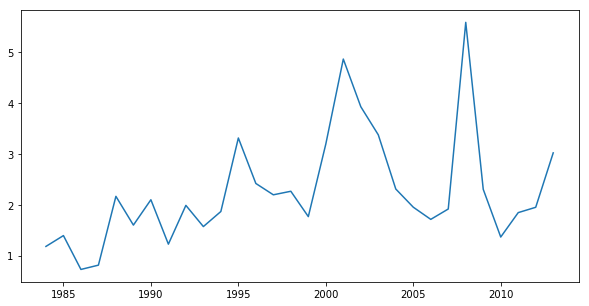

In [18]:
# Check if the score changes much compared to the run without the test data.
amape = AMAPE(interpolated=False)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

In [20]:
fname_submission = '../data/submission/submission_02.csv'
df_submission.to_csv(fname_submission, index=True)